## NBA Home Court Advantage

### Part 1: A First Look at Win Percentages and Point Advantages

In this notebook, we'll take a short look at home court advantage in the NBA. The analysis will use data from the 1996-97 season through the 2016-17 season. We scraped this data from [http://stats.nba.com/](stats.nba.com) in [this notebook](http://nbviewer.jupyter.org/github/practicallypredictable/posts/blob/master/notebooks/scrape-stats_nba-team_matchups.ipynb).

Let's first import the packages we need.

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.float_format = '{:.3f}'.format

We will use [`seaborn`](https://seaborn.pydata.org/) and [`matplotlib`](https://matplotlib.org/) for plotting.

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('notebook')
plt.style.use('ggplot')

We will use the statistics module from the [`scipy`](https://www.scipy.org/) package in a plot at the end of the notebook.

In [3]:
import scipy.stats as stats

In [4]:
from pathlib import Path

In [5]:
PROJECT_DIR = Path.cwd().parent / 'basketball' / 'nba'
INPUT_DIR = PROJECT_DIR / 'data' / 'prepared'
INPUT_DIR.mkdir(exist_ok=True, parents=True)

Let's get the historical matchups we scraped in the previous notebook. In that notebook, the scraped data were saved using Python's [pickle](https://docs.python.org/3/library/pickle.html) format. Refer to the [earlier notebook](http://nbviewer.jupyter.org/github/practicallypredictable/posts/blob/master/notebooks/scrape-stats_nba-team_matchups.ipynb) for more information if you need to scape the data.

In [6]:
def load_nba_historical_matchups(input_dir):
    """Load pickle file of NBA matchups prepared for analytics."""
    PKLFILENAME = 'stats_nba_com-matchups-1996_97-2016_17.pkl'
    pklfile = input_dir.joinpath(PKLFILENAME)
    return pd.read_pickle(pklfile)

In [7]:
matchups = load_nba_historical_matchups(INPUT_DIR)
matchups.shape

(26787, 41)

We have 21 complete seasons of matchup data. Let's just use the regular season matchups for this analysis.

In [8]:
seasons = sorted(list(matchups['season'].unique()))
len(seasons)

21

In [9]:
def prepare_regular_season(matchups):
    df = matchups.copy()
    df = df[df['season_type'] == 'regular']
    df['pt_diff'] = df['pts_h'] - df['pts_a']
    return df

In [10]:
reg = prepare_regular_season(matchups)
reg.shape

(24797, 42)

In [11]:
def home_win_percentage(df):
    games = len(df)
    if games > 0:
        return float(df['won'].value_counts()['H'] / games)
    else:
        return np.nan

In [12]:
home_win_percentage(reg)

0.5980562164777997

The home team has won almost 60% of home games over the past 21 complete seasons. Of course, to win basketball games, you have to score more than the other team. Let's examine what this means in terms of point differentials.

In [13]:
def home_court_analysis(df):
    seasons = sorted(list(df['season'].unique()))
    home_win_pct = [
        home_win_percentage(df.loc[df['season'] == season]) for season in seasons
    ]
    pt_diff_mean = [
        df.loc[df['season'] == season, 'pt_diff'].mean() for season in seasons
    ]
    pt_diff_std = [
        df.loc[df['season'] == season, 'pt_diff'].std() for season in seasons
    ]
    return pd.DataFrame({
        'season': seasons,
        'home_win_pct': home_win_pct,
        'pt_diff_mean': pt_diff_mean,
        'pt_diff_std': pt_diff_std,
    })

In [14]:
hca = home_court_analysis(reg)
hca.describe()

,home_win_pct,pt_diff_mean,pt_diff_std
count,21.000,21.000,21.000
mean,0.598,3.105,12.989
std,0.015,0.385,0.474
min,0.575,2.407,12.030
25%,0.589,2.820,12.669
50%,0.598,3.149,13.057
75%,0.608,3.399,13.342
max,0.628,3.884,13.686


Over this 21 season period, the home team on average scored an extra 3.1 points per game by virtue of playing at home. Let's look at how this has fluctuated season-by-season over the period.

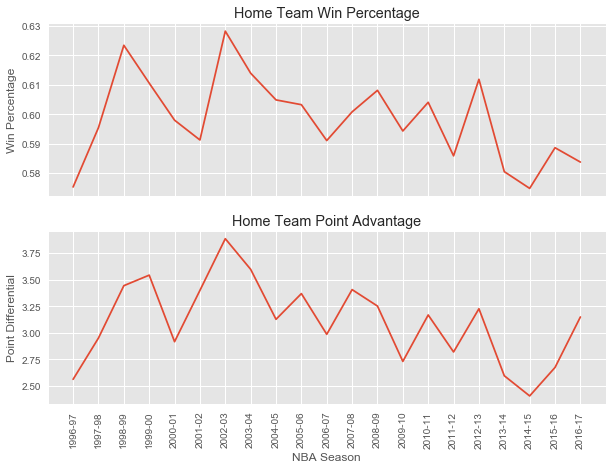

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 7))
hca.plot(y='home_win_pct', ax=ax1, legend=False)
ax1.set_title('Home Team Win Percentage')
ax1.set_ylabel('Win Percentage')
hca.plot(y='pt_diff_mean', ax=ax2, legend=False)
ax2.set_title('Home Team Point Advantage')
ax2.set_ylabel('Point Differential')
plt.xticks(range(len(hca.season)), hca.season, rotation=90)
plt.xlabel('NBA Season')
plt.show()

You can see that there is meaningful variation season-by-season. There may seem to be a hint of a downward trend in the home court win percentage. However, the win percentage is still well within the normal range of variation over this historical period. And looked at in terms of point differential, home court advantage certainly doesn't seem to be trending lower.

[NBA home court advantage was even high in the 1970s](https://fivethirtyeight.com/features/home-field-advantage-english-premier-league/), but we are not going to dwell on the earlier time period at this point. Basketball as played in the NBA has changed a lot since the 1970s.

Now let's focus on just the most recent completed season.

In [16]:
season = seasons[-1]
season

'2016-17'

In [17]:
df = reg[reg['season'] == season]

In [18]:
df['pt_diff'].describe()

count   1230.000
mean       3.149
std       13.686
min      -37.000
25%       -6.000
50%        4.000
75%       12.000
max       49.000
Name: pt_diff, dtype: float64

Although the average home team point differential was 3.15 points for the 2016-17 season, there was a lot of dispersion around this average. Let's plot the point differential.

In [19]:
def get_bins(df):
    min_diff = df['pt_diff'].min()
    max_diff = df['pt_diff'].max()
    return np.arange(2*(round(min_diff/2)-1), 2*(round(max_diff/2)+2), 2)

In [20]:
def plot_score_diff(matchups, ax, season=None):
    if season:
        df = matchups[(matchups['season'] == season)].dropna()
    else:
        df = matchups
    ax = sns.distplot(df['pt_diff'], bins=get_bins(df), kde=False, fit=stats.norm, ax=ax)
    ax.set_xlabel('Point Differential (Home Team Score - Away Team Score)')
    ax.set_ylabel('Frequency')
    if season:
        title = f'Point Differential Frequency for {season} Season'
    else:
        title = f'Point Differential Frequency (All Seasons)'
    ax.set_title(title)
    ax.text(x=35, y=0.008, s='Bins are 2 points wide')
    return ax

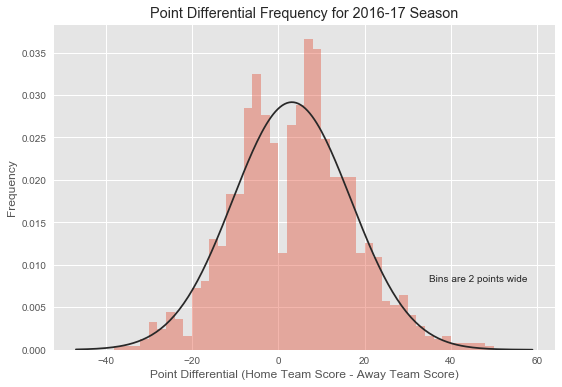

In [21]:
fig, ax = plt.subplots(figsize=(9, 6))
ax = plot_score_diff(reg, ax, season='2016-17')
plt.show()

The curve overlaid on the plot is the bell-shaped [_normal distribution_](https://en.wikipedia.org/wiki/Normal_distribution) that has the same [mean](https://en.wikipedia.org/wiki/Mean) and [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation) as the point differential data. Notice that we used the `scipy` `stats.norm` function with `seaborn` to automatically fit the normal curve to the data.

The fitted curve does a reasonable job of fitting the data away from the center of the distribution, but it does a poor job for the center. Since basketball games can't end in ties, zero is not an allowed point differential. Also, we see that only a little more than 1% of games end within a 2 point margin of victory. So, the normal distribution is too high for small margins of victory, and too low for typical margins of victory.

This suggests that will need to be very careful about how we choose to model and predict NBA point differentials.

To make sure this effect isn't just a coincidence for the 2016-17 season, let's generate the same plot for the entire data set.

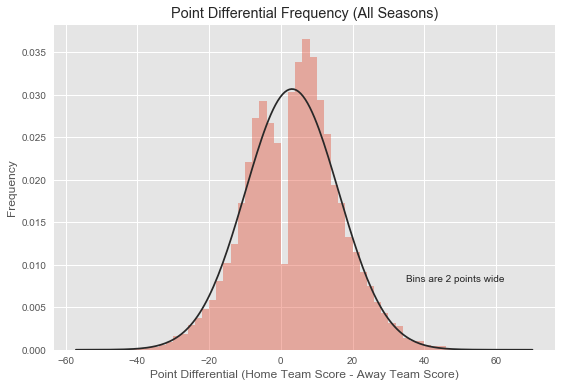

In [22]:
fig, ax = plt.subplots(figsize=(9, 6))
ax = plot_score_diff(reg, ax)
plt.show()

We get the same basic message looking at all 21 seasons. The data look very "normal" away from the center, but aren't in the middle of the distribution. The normal distribution should give you a reasonable approximation for the probability of big blowouts, but doesn't do an adequate job for typical games.